In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import csv
import time
import matplotlib.pyplot as plt

class Mydataset(Dataset):
    
    def __init__(self, x, y=None):
        self.x = torch.FloatTensor(x)
        self.y = y
        if y is not None:
            self.y = torch.FloatTensor(y)
    
    def __getitem__(self, index):
        if self.y is None:
            return self.x[index]
        else:
            return self.x[index], self.y[index]
  
    def __len__(self):
        return len(self.x)

class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.BatchNorm1d(32),
            nn.Dropout(),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
        )
  
    def forward(self, x):
        return self.net(x).squeeze(1)


def init(path, windows=5 , norm=True):
    df = pd.read_csv(path)
    x = df.iloc[:, 1].values
    x = x[np.isnan(x)==False]
    n = len(x)
    data = np.zeros((n - windows, windows), dtype=float)
    y = np.zeros((n - windows, 1), dtype = float)
    for i in range(n - windows):
        data[i, :] = x[i: i + windows]
        y[i] = x[i + windows]
    x = data
    if norm:
        x = (x - x.min()) / (x.max() - x.min())
    return x, y

def test(x, y, model, L):
    test_set = Mydataset(x)
    test_loader = DataLoader(test_set[L:L+10], batch_size=1, shuffle=False)
    model.eval()
    ans = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            test_pred = model(data.cuda())
            for pred in test_pred:
                ans.append(float(pred.cpu().data.numpy()))
    return ans

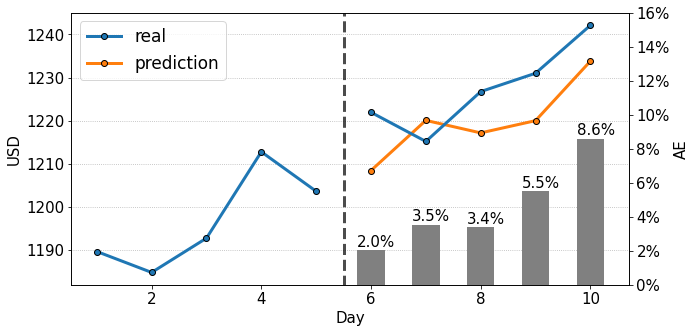

In [2]:
from matplotlib.ticker import FuncFormatter
x, y = init("./LBMA-GOLD.csv")
model = torch.load("Gold_model.pkl")

L = 88
pred = test(x, y, model, L)


fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
                          
ax1.plot([1, 2, 3, 4, 5], y[L:L + 5], linewidth=3, marker = 'o', # 点的形状
         markersize = 6, # 点的大小
         markeredgecolor='black', # 点的边框色
         label = "real"
         )

ax1.plot([6, 7, 8, 9, 10], pred[5:10], linewidth=3, marker = 'o', # 点的形状
         markersize = 6, # 点的大小
         markeredgecolor='black', # 点的边框色
         label = "prediction"
         )
plt.legend(loc=2, fontsize=17)
ax1.plot([6, 7, 8, 9, 10], y[L + 5: L + 10], color = "#1f77b4", linewidth=3, marker = 'o', # 点的形状
         markersize = 6, # 点的大小
         markeredgecolor='black', # 点的边框色
         )
plt.yticks(fontsize=15)
ax1.set_ylabel('USD', fontsize=15)

plt.xlabel('Day', fontsize=15)
plt.xticks(fontsize=15)
ax1.grid(b=True, axis='y', ls=':')
plt.legend(loc=2, fontsize=17)

ax2 = ax1.twinx()
dif = [2.025754, 3.541885, 3.395198, 5.497369, 8.606456]


ax2.bar([6, 7, 8, 9, 10], dif, color = "gray", width=0.5
       )

ax2.yaxis.set_major_formatter(FuncFormatter(lambda x,_:'{}%'.format(int(x))))
ax2.set_ylabel('AE', fontsize=15)
ax2.set_ylim(0,16)

for i in range(len(dif)):
    plt.text(x= i + 6 -0.25, y=dif[i] + 0.2, s = '%.1f%%' % dif[i], fontsize=15)
    
plt.yticks(fontsize=15)

plt.axvline(x=5.5,ymin=-0.5,ymax=1.5,linestyle="dashed", color="black", linewidth=3, alpha=0.7)


plt.savefig("10pred.png")
plt.show()

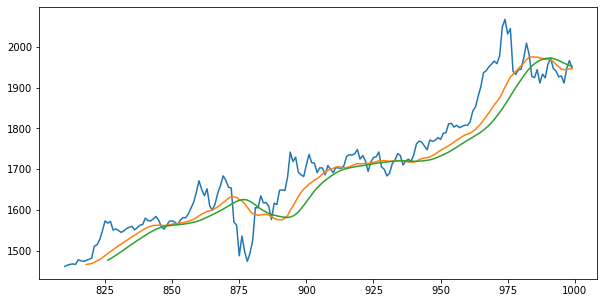

In [159]:
win_short = 19 # MACD短期线 windows 选19
tot = len(y)

MA1 = np.zeros(tot - win_short + 1)
for i in range(tot - win_short + 1):
    MA1[i] = np.sum(y[i:i+win_short]) / win_short

win_long = 9
MA2 = np.zeros(len(MA1) - win_long + 1)


for i in range(len(MA2)):
    MA2[i] = np.sum(MA1[i:i+win_long] / win_long)
    
fig = plt.figure(figsize=(10, 5))

st = 800
lim = 1000 # lim = tot
plt.plot(list(range(st + 10,lim)), y[st + 10:lim])
plt.plot(list(range(st + win_short - 1, lim)), MA1[st:lim - win_short + 1])
plt.plot(list(range(st + win_short + win_long - 2, lim)), MA2[st:lim - (win_short + win_long - 2)])

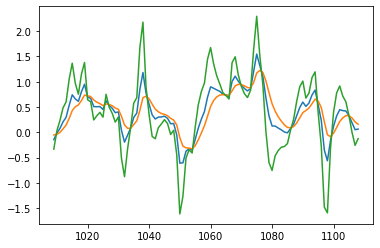

In [174]:
win = 9

rsv = np.zeros(tot - win - 1)
k = np.zeros(tot - win - 1)
d = np.zeros(tot - win - 1)

for i in range(tot - win - 1):
    mi = min(y[i: i+win])
    mx = max(y[i: i+win])
    rsv[i] = (y[i + 10] - mi) / (mx - mi)
    
    if i == 0:
        k[i] = rsv[i]
        d[i] = rsv[i]
    else:
        k[i] = 2/3 * k[i-1] + 1/3 * rsv[i]
        d[i] = 2/3 * d[i-1] + 1/3 * k[i]

j = 3 * np.array(k) - 2 * np.array(d)

st = 1000
ed = 1100
plt.plot(range(st + 9, ed + 9), k[st: ed])
plt.plot(range(st + 9, ed + 9), d[st: ed])
plt.plot(range(st + 9, ed + 9), j[st: ed])

In [4]:
dd, y = init("./LBMA-GOLD.csv", norm=False)
x, y = init("./LBMA-GOLD.csv")
tot = len(dd)

jun = np.zeros(tot - 6)
bia = np.zeros(tot - 6)
rate = np.zeros(tot - 6)

dd = np.array(dd)

test_set = Mydataset(x)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)
model.eval()
ans = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        test_pred = model(data.cuda())
        for pred in test_pred:
            ans.append(float(pred.cpu().data.numpy()))
pred = np.array(ans)


for i in range(tot - 6):
    jun[i] = np.mean(dd[i])
    bia[i] = np.var(dd[i])
    rate[i] = abs(y[i + 5] - pred[i + 5]) / 1.0 * y[i + 5]

rate = (rate - rate.min()) / (rate.max() - rate.min())


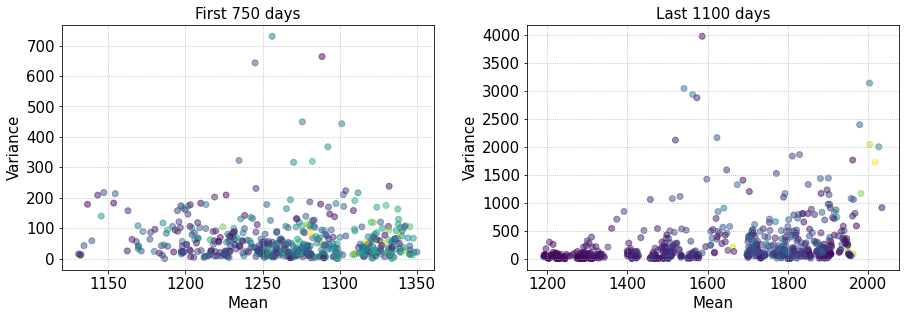

In [75]:
def draw(ax, x, y, z, name):

    
    s1 = ax.scatter(x, y, c=z, alpha=.5)

    ax.grid(b=True, ls=':')

    ax.set_xlabel('Mean', fontsize=15)
    
    
    ax.set_ylabel('Variance', fontsize=15)
    ax.set_title(name, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    

    
fig = plt.figure(figsize=(15, 4.5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.25)
ax1=plt.subplot(121)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax2=plt.subplot(122)

fj = 500
draw(ax1, jun[0:fj], bia[0:fj], rate[0:fj], "First 750 days")

draw(ax2, jun[fj:], bia[fj:], rate[fj:], "Last 1100 days")

plt.savefig("gold_analyse_mean_and_var.png")
plt.show()